In [96]:
from torch_geometric.datasets import TUDataset
from torch_geometric.loader import DataLoader
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch_geometric.nn import GINConv, global_add_pool
from torchmetrics.classification import Accuracy
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx

In [5]:
dataset=TUDataset('E:/glass_git/ML-DL/Graph/data',name='PROTEINS').shuffle()
train_dataset=dataset[:int(len(dataset)*0.8)]
val_dataset=dataset[int(len(dataset)*0.8):int(len(dataset)*0.9)]
test_dataset=dataset[int(len(dataset)*0.9):]

print(f'train set: {len(train_dataset)}')
print(f'val set: {len(val_dataset)}')
print(f'test set: {len(test_dataset)}')


train set: 890
val set: 111
test set: 112


In [63]:
from collections import Counter
Counter(dataset.y.tolist())

Counter({0: 663, 1: 450})

In [6]:
tarin_loader=DataLoader(train_dataset,batch_size=64, shuffle=True)
val_loader=DataLoader(val_dataset,batch_size=64, shuffle=True)
test_loader=DataLoader(test_dataset,batch_size=64, shuffle=True)

In [91]:
'''
    x의 column : feature 수 (3개) 
    x의 row    : 데이터 개수
    y : x의 class 라벨
'''
for i, batch in enumerate(tarin_loader):
    print(f'batch {i}: {batch}')
    

batch 0: DataBatch(edge_index=[2, 11154], x=[2892, 3], y=[64], batch=[2892], ptr=[65])
batch 1: DataBatch(edge_index=[2, 9070], x=[2438, 3], y=[64], batch=[2438], ptr=[65])
batch 2: DataBatch(edge_index=[2, 7284], x=[1938, 3], y=[64], batch=[1938], ptr=[65])
batch 3: DataBatch(edge_index=[2, 10224], x=[2625, 3], y=[64], batch=[2625], ptr=[65])
batch 4: DataBatch(edge_index=[2, 9656], x=[2646, 3], y=[64], batch=[2646], ptr=[65])
batch 5: DataBatch(edge_index=[2, 8500], x=[2268, 3], y=[64], batch=[2268], ptr=[65])
batch 6: DataBatch(edge_index=[2, 8520], x=[2263, 3], y=[64], batch=[2263], ptr=[65])
batch 7: DataBatch(edge_index=[2, 8966], x=[2480, 3], y=[64], batch=[2480], ptr=[65])
batch 8: DataBatch(edge_index=[2, 8122], x=[2253, 3], y=[64], batch=[2253], ptr=[65])
batch 9: DataBatch(edge_index=[2, 9824], x=[2543, 3], y=[64], batch=[2543], ptr=[65])
batch 10: DataBatch(edge_index=[2, 11234], x=[2961, 3], y=[64], batch=[2961], ptr=[65])
batch 11: DataBatch(edge_index=[2, 9778], x=[2643,

In [ ]:
'''
첫번째 행 : 출발 노드
두번째 행 : 도착 노드
0노드->1노드 로 가는 edge이 있음
0노드 -> 100노드로 가는 edge이 있음
34590노드 -> 34589노드로 가는 edge이 있음 
'''
train_dataset.edge_index

tensor([[    0,     0,     1,  ..., 34590, 34590, 34590],
        [    1,   100,     0,  ..., 34580, 34581, 34589]])

In [107]:
# model
class GIN(nn.Module):
    def __init__(self,dim_h):
        super(GIN,self).__init__()
        self.conv1=GINConv(nn.Sequential(nn.Linear(dataset.num_node_features,dim_h),
                                         nn.BatchNorm1d(dim_h),
                                         nn.ReLU(),
                                         nn.Linear(dim_h,dim_h),
                                         nn.ReLU()))
        self.conv2=GINConv(nn.Sequential(nn.Linear(dim_h,dim_h),
                                         nn.BatchNorm1d(dim_h),
                                         nn.ReLU(),
                                         nn.Linear(dim_h,dim_h),
                                         nn.ReLU()))
        self.conv3=GINConv(nn.Sequential(nn.Linear(dim_h,dim_h),
                                         nn.BatchNorm1d(dim_h),
                                         nn.ReLU(),
                                         nn.Linear(dim_h,dim_h),
                                         nn.ReLU()))
        self.lin1=nn.Linear(dim_h*3,dim_h*3)
        self.lin2=nn.Linear(dim_h*3, dataset.num_classes)
    
    def forward(self,x,edge_index,batch):
        #node embedding
        h1=self.conv1(x,edge_index)
        h2=self.conv2(h1,edge_index)
        h3=self.conv3(h2,edge_index)

        #graph-level readout
        h1=global_add_pool(h1,batch)
        h2=global_add_pool(h2,batch)
        h3=global_add_pool(h3,batch)

        #concate graph embeddings
        h=torch.cat((h1,h2,h3),dim=1)

        h=self.lin1(h)
        h=h.relu()
        h=F.dropout(h,p=0.5,training=self.training)
        h=self.lin2(h)

        return F.log_softmax(h, dim=1)
    
def train(model,loader):
    criterion=nn.CrossEntropyLoss()
    optim=torch.optim.Adam(model.parameters(),lr=0.01)
    accuracy=Accuracy(task='binary')
    epochs=100

    model.train()
    for epoch in range(epochs+1):
        total_loss=0
        acc=0
        val_loss=0
        val_acc=0

        for i,data in enumerate(loader):
            print(f'batch_size: {i}, len(loader): {len(loader)}, led(data):{len(data)}')
            optim.zero_grad()
            out=model(data.x,data.edge_index,data.batch)
            loss=criterion(out,data.y)
            total_loss += loss/len(loader)
            acc += accuracy(out.argmax(dim=1),data.y) /len(loader) #accuracy: 1개 batch에 속한 data의 평균 값, len(loader)
            loss.backward()
            optim.step()

            val_loss, val_acc=test(model,val_loader)

        if(epoch%20==0):
            print(f'epoch: {epoch}, train loss : {total_loss:.2f},train acc : {acc*100:.2f}%, val loss: {val_loss:.2f}, val acc: {val_acc:5.2f}%')

    return model

@torch.no_grad()    
def test(model,loader):
    criterion=nn.CrossEntropyLoss()
    accuracy=Accuracy(task='binary')
    model.eval()
    loss=0
    acc=0
    for data in loader:
        out=model(data.x,data.edge_index,data.batch)
        loss += criterion(out,data.y)/len(loader)
        acc  += accuracy(out.argmax(dim=1),data.y)/len(loader)
    return loss, acc


In [108]:
gin=GIN(dim_h=64)
gin=train(gin,tarin_loader)


batch_size: 0, len(loader): 14, led(data):64
batch_size: 1, len(loader): 14, led(data):64
batch_size: 2, len(loader): 14, led(data):64
batch_size: 3, len(loader): 14, led(data):64
batch_size: 4, len(loader): 14, led(data):64
batch_size: 5, len(loader): 14, led(data):64
batch_size: 6, len(loader): 14, led(data):64
batch_size: 7, len(loader): 14, led(data):64
batch_size: 8, len(loader): 14, led(data):64
batch_size: 9, len(loader): 14, led(data):64
batch_size: 10, len(loader): 14, led(data):64
batch_size: 11, len(loader): 14, led(data):64
batch_size: 12, len(loader): 14, led(data):64
batch_size: 13, len(loader): 14, led(data):58
epoch: 0, train loss : 9.94,train acc : 58.40%, val loss: 0.75, val acc:  0.54%
batch_size: 0, len(loader): 14, led(data):64
batch_size: 1, len(loader): 14, led(data):64
batch_size: 2, len(loader): 14, led(data):64
batch_size: 3, len(loader): 14, led(data):64
batch_size: 4, len(loader): 14, led(data):64
batch_size: 5, len(loader): 14, led(data):64
batch_size: 6, l

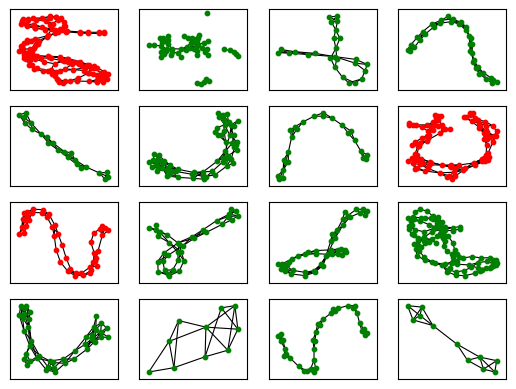

In [ ]:
fig, ax =plt.subplots(4,4)

for i, data in enumerate(dataset[-16:]):
    out=gin(data.x,data.edge_index,data.batch)
    color='green' if out.argmax(dim=1)==data.y else 'red'
    
    ix=np.unravel_index(i,ax.shape) #(index,matrix)  matrix에서 index값의 위치 찾기 
    ax[ix].axis=('off')
    G=to_networkx(dataset[i], to_undirected=True)
    nx.draw_networkx(G,
                    pos=nx.spring_layout(G, seed=0),
                    with_labels=False,
                    node_size=10,
                    node_color=color,
                    width=0.8,
                    ax=ax[ix])